**Adbot Ad Engagement Forecasting Challenge**


  

*   In a digital ecosystem saturated with advertisements, accurately predicting
  success is pivotal for businesses. Adbot aims to empower its small business clients with actionable insights to refine their ad campaigns and bolster customer engagement.



*   The objective of this challenge is to accurately predict the number of clicks a client’s ad receives, one and two weeks into the future (in digital marketing, clicks refer to when someone views the advert and follows one of the hyperlinks in that advert). Winning solutions will further be required to submit a description of the variables that had the most significant impact on engagement (number of clicks). It is therefore important that the models you build are not only accurate, but also interpretable.





In [ ]:
!pip install statsmodels --q

 Import Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import Image
from datetime import datetime, date
import statistics

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pylab as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment', None)

**Data LOading**

In [ ]:
df = pd.read_csv('Train (9).csv')
submission = pd.read_csv('SampleSubmission (13).csv')

**Data visualization**

In [ ]:
df.head()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,142.0,15.0,3393.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,5.0,11.0
1,89.0,8.0,1817.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0
2,59.0,8.0,1743.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,10.0
3,78.0,4.0,917.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,3.0,13.0
4,20.0,1.0,217.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0


In [ ]:
df.describe()

,impressions,clicks,cost,conversions,duration,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
count,289526.000000,289526.000000,289526.000000,289526.000000,36900.000000,289926.000000,280071.000000,289526.000000,289526.000000,289526.000000
mean,72.809620,8.039927,2208.525051,0.790140,67.968970,16.656556,0.127928,2.745584,2.879824,10.706165
std,153.592792,36.241161,7392.609733,10.298258,98.055148,12.186418,0.526362,1.571108,1.670356,4.509450
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000,9.990000,0.000000,2.000000,1.000000,10.000000
50%,23.000000,2.000000,553.000000,0.000000,36.000000,11.421975,0.000000,3.000000,3.000000,12.000000
75%,69.000000,6.000000,2062.500000,0.000000,95.000000,20.122939,0.000000,4.000000,4.000000,14.000000
max,6833.000000,4227.000000,719928.000000,1297.000000,2125.000000,100.000000,8.000000,7.000000,7.000000,20.000000


Since this is a TimeSeries problem, we have to parse 'date' column

In [ ]:
df['date'] = df['date'].fillna(pd.to_datetime(df['date'], errors='coerce'))
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,142.000000,15.000000,3393.000000,0.000000,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,nan,nan,nan,nan,nan,nan,16.279669,0.000000,2.000000,5.000000,11.000000
1,89.000000,8.000000,1817.000000,0.000000,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,nan,nan,nan,nan,nan,nan,16.279669,0.000000,2.000000,2.000000,13.000000
2,59.000000,8.000000,1743.000000,0.000000,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,nan,nan,nan,nan,nan,nan,16.279669,0.000000,2.000000,2.000000,10.000000
3,78.000000,4.000000,917.000000,0.000000,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,nan,nan,nan,nan,nan,nan,16.279669,0.000000,2.000000,3.000000,13.000000
4,20.000000,1.000000,217.000000,0.000000,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,nan,nan,nan,nan,nan,nan,16.279669,0.000000,2.000000,2.000000,13.000000


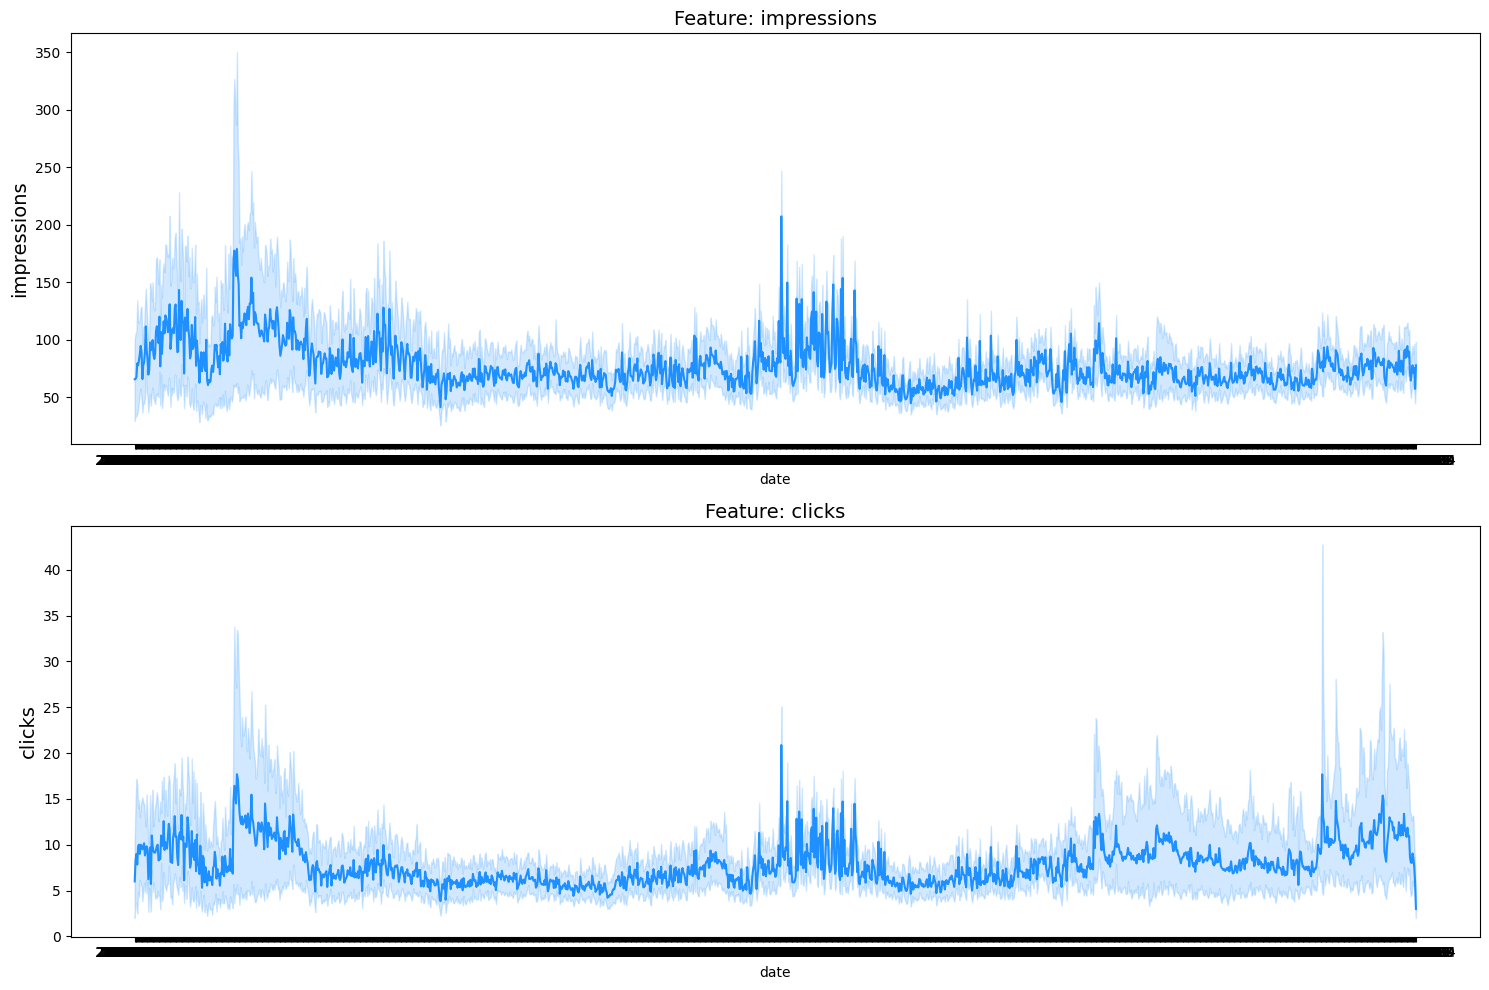

In [ ]:
# Select a subset of features to plot
subset_columns = df.columns[0:2]
num_features = len(subset_columns)

f, ax = plt.subplots(nrows=num_features, ncols=1, figsize=(15, 5 * num_features))

for i, column in enumerate(subset_columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)

plt.tight_layout()
plt.show()


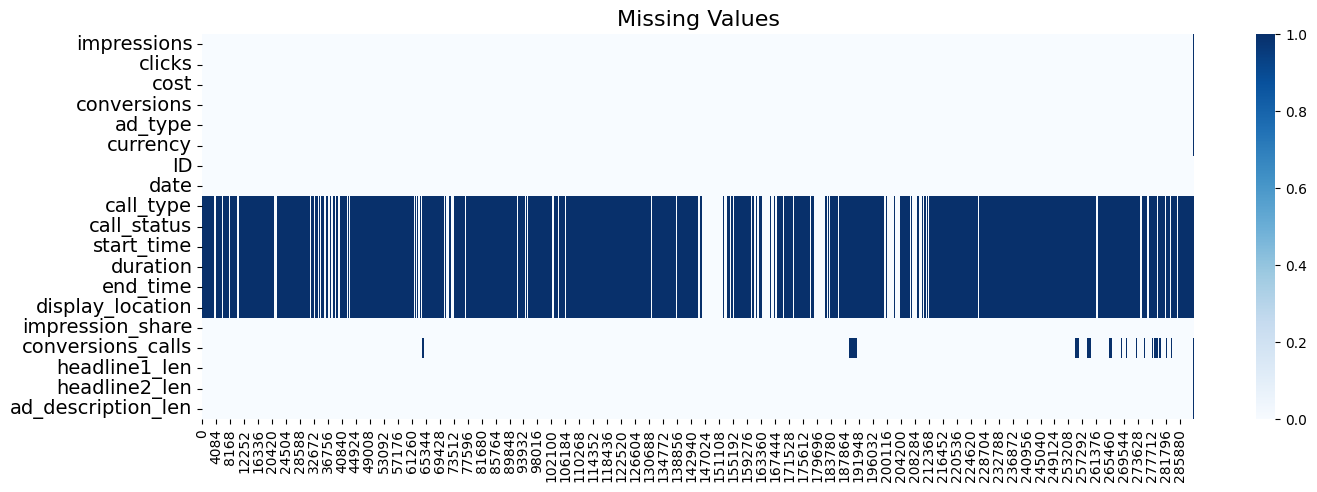

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

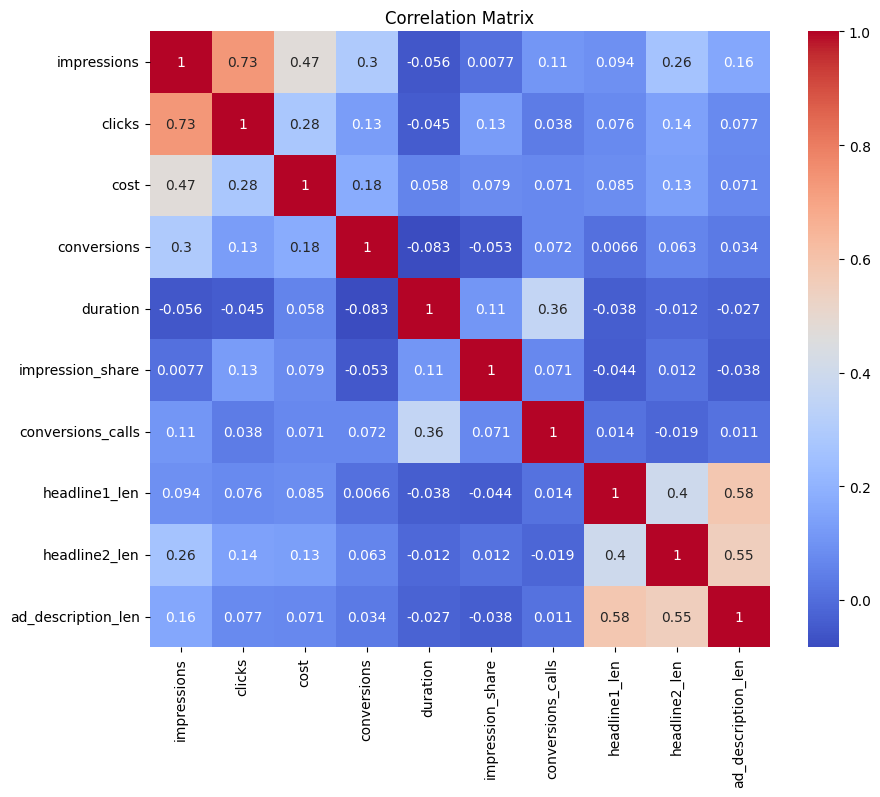

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_columns.corr()
clicks_correlation = correlation_matrix['clicks'].abs().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


**Data preparation: Preprocessing ⚙️**

In [ ]:
df = df.dropna(subset=['clicks'])
df.reset_index(drop=True, inplace=True)

In [ ]:
df['clicks'] = df.groupby('headline2_len')['clicks'].transform(lambda x: np.where(x >= x.quantile(0.97), x.quantile(0.97), x))#grouping with headline2_len column

df = df[['ID', 'date','clicks']]
df = df.sort_values(by=['ID', 'date']).reset_index(drop=True)

grouped_df = df.groupby(['date', 'ID']).sum()
grouped_df = grouped_df.reset_index()
grouped_df['date'] = pd.to_datetime(grouped_df['date'])

In [ ]:
grouped_df.head(2)

,date,ID,clicks,cost,impressions
0,2020-01-01,ID_5da86e71bf5dee4cf5047046,36.0,8087.0,393.0
1,2020-01-02,ID_5da86e71bf5dee4cf5047046,50.0,9831.0,395.0


**Techniques Used**

**Moving Average Forecast**

*  Calculates the average of the last 'window' observations
Assumes future values will follow the recent trend
Simple and straightforward approach.


**Weighted Average Forecast**


*   Assigns exponentially decaying weights to the last 'window' observations
Gives more importance to recent observations
'weight_decay' parameter controls how quickly weights decay.



**Weighted Average Forecast with ARIMA Model**

*   Combines weighted average with ARIMA model forecast
Fits ARIMA model and generates forecast
Calculates weighted average of last 'window' observations
Final forecast is a combination of weighted average and ARIMA forecast.


The code also includes a helper function 'add_dynamic_forecasts' that generates forecasts for time series groups and handles data preparation.
The main code block iterates over groups of time series data, calls 'add_dynamic_forecasts' for each group, and concatenates the original and forecasted data into a single DataFrame.
The forecasting techniques are suitable for time series data exhibiting trends or seasonality, as they capture underlying patterns. Moving average is simple but may struggle with abrupt changes. Weighted average is more responsive to changes, and the ARIMA model captures long-term patterns and trends.
These techniques are widely used in finance, economics, and business for tasks like sales forecasting, demand forecasting, and trend analysis.

![Flowchat](https://raw.githubusercontent.com/mubrij/Flowchat/main/Screenshot%202024-05-29%20162246.png)


In [ ]:
forecast_columns = ['clicks']

def dynamic_forecast_moving_average(series, window, forecast_horizon):
    values = list(series.dropna())
    if not values:
        return [np.nan] * forecast_horizon

    for _ in range(forecast_horizon):
        moving_avg = np.mean(values[-window:]) if len(values) >= window else np.mean(values)
        values.append(moving_avg)

    return values[-forecast_horizon:]

def dynamic_forecast_weighted_average(series, window, forecast_horizon, weight_decay=0.6):
    values = list(series.dropna())
    if not values:
        return [np.nan] * forecast_horizon

    weights = np.array([weight_decay ** i for i in range(window)])
    weights = weights / weights.sum()

    for _ in range(forecast_horizon):
        if len(values) >= window:
            weighted_avg = np.dot(values[-window:], weights)
        else:
            weighted_avg = np.mean(values)
        values.append(weighted_avg)

    return values[-forecast_horizon:]


def dynamic_forecast_weighted_average_arima(series, window, forecast_horizon, weight_decay=0.6, order=(1, 1, 1)):
    """
    Generates forecasts using a weighted average of ARIMA model forecasts.

    Args:
        series (pandas.Series): The time series data.
        window (int): The window size for the weighted average.
        forecast_horizon (int): The number of future periods to forecast.
        weight_decay (float): The decay factor for the weighted average.
        order (tuple): The order of the ARIMA model (p, d, q).

    Returns:
        list: A list of forecasted values.
    """
    values = list(series.dropna())
    if not values:
        return [np.nan] * forecast_horizon

    weights = np.array([weight_decay ** i for i in range(window)])
    weights = weights / weights.sum()

    model = ARIMA(series, order=order)
    model_fit = model.fit()

    forecasts = []
    for _ in range(forecast_horizon):
        if len(values) >= window:
            arima_forecast = model_fit.forecast()[0]
            weighted_avg = np.dot(values[-window:], weights) + (1 - weights.sum()) * arima_forecast
        else:
            weighted_avg = np.mean(values)
        values.append(weighted_avg)
        forecasts.append(weighted_avg)

    return forecasts

def add_dynamic_forecasts(group, forecast_horizon, window, forecast_method):
    group = group.set_index('date')
    group.index = pd.to_datetime(group.index)
    group = group.asfreq('D', method='ffill')
    last_date = group.index.max()
    forecast_dates = pd.date_range(start=last_date, periods=forecast_horizon + 1, freq='D')[1:]
    forecast_data = {}

    for col in forecast_columns:
        if forecast_method == 'weighted_average':
            forecast_data[col] = dynamic_forecast_weighted_average(group[col], window, forecast_horizon)
        elif forecast_method == "arima_weight":
            forecast_data[col] = dynamic_forecast_weighted_average_arima(group[col], window, forecast_horizon)

    forecast_df = pd.DataFrame(forecast_data, index=forecast_dates)
    forecast_df['ID'] = group['ID'].iloc[0]
    forecast_df['is_forecast'] = True
    group = group.reset_index()
    forecast_df = forecast_df.reset_index().rename(columns={'index': 'date'})

    return forecast_df


all_data = []
window_size = 12
forecast_horizon = 16
forecast_method = 'arima_weight'  # Choose 'moving_average' or 'weighted_average' or 'arima_weight'

for name, group in grouped_df.groupby(['ID']):
    forecast_df = add_dynamic_forecasts(group, forecast_horizon, window_size, forecast_method)
    all_data.append(pd.concat([group.reset_index(drop=True), forecast_df]))

grouped_df = pd.concat(all_data).sort_values(by=['ID', 'date'])
grouped_df['is_forecast'] = grouped_df['is_forecast'].fillna(False)

The two lines of code you provided are used to split the original DataFrame grouped_df into two separate DataFrames: train and test.

The purpose of splitting the data into train and test DataFrames is to separate the historical data from the forecasted data.

In [ ]:
train = grouped_df[grouped_df['is_forecast'] == False]
test = grouped_df[grouped_df['is_forecast'] == True]

In [ ]:
sub = submission.copy()

sub[['year', 'month', 'day']] = sub['ID'].str.extract(r'_(\d{4})_(\d{2})_(\d{2})')
sub['ID'] = sub['ID'].str.replace(r'(_\d{4}_\d{2}_\d{2})$', '', regex=True)

sub['date'] = pd.to_datetime(sub[['year', 'month', 'day']])
sub.head(5)

,ID,clicks,year,month,day,date
0,ID_5da86e71bf5dee4cf5047046,0,2024,01,22,2024-01-22
1,ID_5da86e71bf5dee4cf5047046,0,2024,01,29,2024-01-29
2,ID_5e43c29e6279884e2827d894,0,2024,02,21,2024-02-21
3,ID_5e43c29e6279884e2827d894,0,2024,02,28,2024-02-28
4,ID_5e4e7b480e374330ee151305,0,2023,12,04,2023-12-04


In [ ]:
filtered_test = pd.merge(test, sub[['ID', 'date']], on=['ID', 'date'])
merge_df = pd.merge(sub, filtered_test, on=['ID', 'date'], how='left')

click_sums = merge_df.groupby(['ID', 'date'])['clicks_y'].sum().reset_index()
click_sums.rename(columns={'clicks_y': 'sum_clicks'}, inplace=True)

sub = pd.merge(sub, click_sums, on=['ID', 'date'], how='left')
sub['clicks'] = sub['sum_clicks']

sub.drop(columns='sum_clicks', inplace=True)

In [ ]:
sub['clicks'] = sub['clicks'].round()
submission['clicks'] = sub['clicks']

In [ ]:
submission.to_csv('forecasted.csv', index=False)

In [ ]:
submission.head(10)

,ID,clicks
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,111.0
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,111.0
2,ID_5e43c29e6279884e2827d894_2024_02_21,4.0
3,ID_5e43c29e6279884e2827d894_2024_02_28,5.0
4,ID_5e4e7b480e374330ee151305_2023_12_04,4.0
5,ID_5e4e7b480e374330ee151305_2023_12_11,4.0
6,ID_5e8ad56cd4090270567b6c58_2024_02_21,20.0
7,ID_5e8ad56cd4090270567b6c58_2024_02_28,19.0
8,ID_5e8b4f12d8709943490cd775_2023_09_24,9.0
9,ID_5e8b4f12d8709943490cd775_2023_10_01,10.0
